# Hyperparameter tuning for summarization model (Encoder-Decoder with attention)
Authors: Elisa Nguyen and Daphne Theodorakopoulos

modified version based on Tutorial from https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/

In [ ]:
!pip install py-rouge

In [ ]:
import rouge
import numpy as np  
import pandas as pd 
pd.set_option("display.max_colwidth", 200)          
from tensorflow.keras.layers import Layer, Input, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, LSTM

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.engine import base_layer_v1
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.ops import array_ops, math_ops
import sys
from AttentionLayer import AttentionLayer

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences 
from nltk.corpus import stopwords
import nltk
from tensorflow.python.ops import array_ops
nltk.download('stopwords')
nltk.download('punkt')

## 2. Import data

- load test, train, val
- tokenize and convert findings and conclusions to numerical sequence

In [ ]:
x_train = pd.read_excel('x_train.xlsx')
y_train = pd.read_excel('y_train.xlsx')
x_val = pd.read_excel('x_val.xlsx')
y_val = pd.read_excel('y_val.xlsx')
x_test = pd.read_excel('x_test.xlsx')
y_test = pd.read_excel('y_test.xlsx')

max_len_text = 100 
max_len_summary = 32 

In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(filters='!"$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
x_tokenizer.fit_on_texts(list(x_train['cleaned_text']))

#convert text sequences into integer sequences
x_train['text_sequence'] = x_tokenizer.texts_to_sequences(x_train['cleaned_text'])
x_val['text_sequence'] = x_tokenizer.texts_to_sequences(x_val['cleaned_text'])
x_test['text_sequence'] = x_tokenizer.texts_to_sequences(x_test['cleaned_text'])

#padding zero upto maximum length
x_train['text_sequence'] = x_train['text_sequence'].apply(lambda x: pad_sequences([x], maxlen= max_len_text, padding='post')[0]) 
x_val['text_sequence'] = x_val['text_sequence'].apply(lambda x: pad_sequences([x], maxlen= max_len_text, padding='post')[0])
x_test['text_sequence'] = x_test['text_sequence'].apply(lambda x: pad_sequences([x], maxlen= max_len_text, padding='post')[0])

x_voc_size = len(x_tokenizer.word_index) +1

In [ ]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer(filters='!"$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
y_tokenizer.fit_on_texts(list(y_train['cleaned_summary']))

#convert summary sequences into integer sequences
y_train['text_sequence'] = y_tokenizer.texts_to_sequences(y_train['cleaned_summary']) 
y_val['text_sequence']= y_tokenizer.texts_to_sequences(y_val['cleaned_summary']) 
y_test['text_sequence']= y_tokenizer.texts_to_sequences(y_test['cleaned_summary']) 

#padding zero upto maximum length
y_train['text_sequence'] = y_train['text_sequence'].apply(lambda x: pad_sequences([x], maxlen= max_len_summary, padding='post')[0])
y_val['text_sequence']= y_val['text_sequence'].apply(lambda x: pad_sequences([x], maxlen= max_len_summary, padding='post')[0])
y_test['text_sequence'] = y_test['text_sequence'].apply(lambda x: pad_sequences([x], maxlen= max_len_summary, padding='post')[0])

y_voc_size  =len(y_tokenizer.word_index) +1

## 3. Set up model functions

- Model definition
- Model inference
- Evaluators

In [ ]:
def define_model(latent_dim):
  """
  Function to define the Encoder-Decoder model with attention
  :param latent_dim: int, number of hidden units per layer
  :returns model with decoder layers, attention layer, encoder input & output & states, decoder input
  """
  with tf.device('/device:GPU:0'):  
    K.clear_session() 
    latent_dim = latent_dim 

    # Encoder 
    encoder_inputs = Input(shape=(max_len_text,)) 
    enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

    #LSTM 1 
    encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True)
    encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

    #LSTM 2 
    encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True)
    encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

    #LSTM 3 
    encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True) 
    encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

    # Set up the decoder. 
    decoder_inputs = Input(shape=(None,)) 
    dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
    dec_emb = dec_emb_layer(decoder_inputs) 

    #LSTM using encoder_states as initial state
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
    decoder_outputs1,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

    #Attention Layer
    attn_layer = AttentionLayer(name='attention_layer') 
    attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs1]) 

    # Concat attention output and decoder LSTM output 
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs1, attn_out])

    #Dense layer
    decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
    decoder_outputs = decoder_dense(decoder_concat_input) 

    # Define the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
    model.summary()
    return model, encoder_inputs, encoder_outputs, state_h, state_c, decoder_inputs, dec_emb_layer, decoder_lstm, attn_layer, decoder_dense

In [ ]:
def model_inference(latent_dim, encoder_inputs, encoder_outputs, state_h, state_c, decoder_inputs, dec_emb_layer, decoder_lstm, attn_layer, decoder_dense):
  """
  Function to do model inference to freeze the trained model and use it
  :param latent_dim: int, number of hidden units in each layer
  :param encoder_inputs: Input object for encoder
  :param encoder_outputs: tensor, representing context vector
  :param state_h: tensor, hidden state of the last encoder unit
  :param state_c: tensor, cell state of the last encoder unit
  :param decoder_inputs: Input object for decoder
  :param dec_emb_layer: Embedding layer of the decoder
  :param decoder_lstm: LSTM layer of the decoder
  :param attn_layer: Attention layer of the decoder
  :param decoder_dense: Dense layer of the decoder
  :returns inferred encoder model, inferred decoder model
  """
  with tf.device('/device:GPU:0'):  
    # encoder inference
    encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

    # decoder inference
    # Below tensors will hold the states of the previous time step
    decoder_state_input_h = Input(shape=(latent_dim,))
    decoder_state_input_c = Input(shape=(latent_dim,))
    decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

    # Get the embeddings of the decoder sequence
    dec_emb2= dec_emb_layer(decoder_inputs)

    # To predict the next word in the sequence, set the initial states to the states from the previous time step
    decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

    #attention inference
    attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
    decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_outputs2 = decoder_dense(decoder_inf_concat)

    # Final decoder model
    decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c], [decoder_outputs2] + [state_h2, state_c2])
    return encoder_model, decoder_model

In [ ]:
def decode_sequence(input_seq, encoder_model, decoder_model):
  """
  Function to decode an input sequence, so to generate a conclusion to a finding
  :param input_seq: sequence of ints, numerical representation of preprocessed findings
  :param encoder_model: inferred encoder model
  :param decoder_model: inferred decoder model
  :returns decoded sequence as text (string)
  """
  with tf.device('/device:GPU:0'):
      reverse_target_word_index=y_tokenizer.index_word 
      reverse_source_word_index=x_tokenizer.index_word 
      target_word_index=y_tokenizer.word_index
      # Encode the input as state vectors.
      e_out, e_h, e_c = encoder_model.predict(input_seq)

      # Generate empty target sequence of length 1.
      target_seq = np.zeros((1,1))

      # Chose the 'start' word as the first word of the target sequence
      target_seq[0, 0] = target_word_index['start']

      stop_condition = False
      decoded_sentence = ''
      i=0
      while not stop_condition:
          output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

          # Sample a token
          sampled_token_index = np.argmax(output_tokens[0, -1, :])
          if sampled_token_index == 0:
            sampled_token='end'
            stop_condition = True
          else:
            sampled_token = reverse_target_word_index[sampled_token_index]

          if(sampled_token!='end'):
              decoded_sentence += ' '+sampled_token

              # Exit condition: either hit max length or find stop word.
              if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                  stop_condition = True

          # Update the target sequence (of length 1).
          target_seq = np.zeros((1,1))
          target_seq[0, 0] = sampled_token_index

          # Update internal states
          e_h, e_c = h, c
          i += 1
          if i == (max_len_text +1):
            stop_condition=True
  return decoded_sentence

In [ ]:
evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l'],
                           max_n=2,
                           limit_length=False,
                           #length_limit=100,
                           #length_limit_type='words',
                           #apply_avg=apply_avg,
                          # apply_best=apply_best,
                           alpha=0.5, # Default F1_score
                           #weight_factor=1.2,
                           stemming=True)

In [ ]:
def birads_score(row):
  pre = ['birads classificatie', 'birads', 'birads-classificatie', 'birads calcificatie']
  sec = [' rechts', ' links', ' beiderzijds', ' beide','',' ',':',' code','-code', ' categorie', ' echografisch']
  mid = ['','-',' ','- ', ' echografisch ', ' rechts ', ' links ', ' beiderzijds ', ' thans ']
  dic = {0:['0'],1:['1','i', 'een'], 2:['l2','2','ii', 'twee'], 3:['3','iii', 'drie'], 
         4:['4','iv', 'vier'], 5:['5', 'vijf','v'], 6:['6','vi', 'zes']}
  for i in range(6,-1,-1): 
    for p in pre: 
      for s in sec:
        for m in mid:
          for val in dic[i]:
            if (p +s+ m+ val) in row:
              return i

## 3. Hyperparameter tuning

- for each hyperparameter combination of Batch sizes 64, 128, 256, 512 and latent dimensions 60, 80, 100, 120
- train model on training set, with early stopping measured on loss on validation set
- use trained model to generate conclusions for validation set
- evaluate using ROUGE and accuracy
- write all results to excel

In [ ]:
with tf.device('/device:GPU:0'):
  batch_sizes = [64, 128, 256, 512]
  latent_dims = [60, 80, 100, 120]
  df_result = pd.DataFrame(columns=['findings', 'original', 'score', 'predicted', 'birads_predicted', 'rouge', 'birads_accuracy', 'epoch', 'val_loss'])
  df_result['findings']= x_val['cleaned_text']
  df_result['original'] = y_val['cleaned_summary']
  df_result['score'] = x_val['score']
  x_val_reshaped = [x_val['text_sequence'][i].reshape(1,max_len_text) for i in range(len(x_val))]

  for batch_size in batch_sizes:
    for latent_dim in latent_dims:
      #define model
      model, encoder_inputs, encoder_outputs, state_h, state_c, decoder_inputs, dec_emb_layer, decoder_lstm, attn_layer, decoder_dense = define_model(latent_dim)
      
      #compile and train model
      model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
      es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, restore_best_weights=True, patience=20)
      history=model.fit([np.array(list(x_train['text_sequence'])), np.array(list(y_train['text_sequence']))[:,:-1]], np.array(list(y_train['text_sequence'])).reshape(np.array(list(y_train['text_sequence'])).shape[0],np.array(list(y_train['text_sequence'])).shape[1], 1)[:,1:] ,epochs=100,callbacks=[es],batch_size=batch_size, validation_data=([np.array(list(x_val['text_sequence'])),np.array(list(y_val['text_sequence']))[:,:-1]], np.array(list(y_val['text_sequence'])).reshape(np.array(list(y_val['text_sequence'])).shape[0],np.array(list(y_val['text_sequence'])).shape[1], 1)[:,1:]))
      model.save_weights('path' + str(latent_dim) + 'bs' + str(batch_size))
      
      #decode
      encoder_model, decoder_model = model_inference(latent_dim, encoder_inputs, encoder_outputs, state_h, state_c, decoder_inputs, dec_emb_layer, decoder_lstm, attn_layer, decoder_dense)
      df_result['predicted'] = pd.Series(x_val_reshaped).apply(lambda x: decode_sequence([x], encoder_model=encoder_model, decoder_model=decoder_model))
      df_result['birads_predicted'] = df_result['predicted'].apply(birads_score)
      
      #evaluate
      all_hypothesis = list(df_result['predicted'])
      all_references = list(df_result['original'])
      scores = evaluator.get_scores(all_hypothesis, all_references)
      df_result.loc[0, 'rouge'] = scores
      df_result.loc[0, 'birads_accuracy'] = df_result[df_result['score']==df_result['birads_predicted']].shape[0]/df_result.shape[0]
      df_result.loc[0, 'epoch'] = np.array(history.history['val_loss']).argmin()
      df_result.loc[0, 'val_loss'] = history.history['val_loss'][np.array(history.history['val_loss']).argmin()]

      #save results
      df_result.to_excel('path/result_encoder_decoder_attention_dim' + str(latent_dim) + 'bs' + str(batch_size) + '.xlsx', index=False)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 80)      1051360     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 80), (N 51520       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

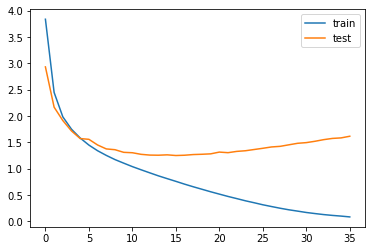

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()